In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, mannwhitneyu
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing
# print(tf.__version__)

In [2]:
# function for splitting the dataset indices into training (75%) and testing (25%) sets
def select_indices_percent(data, train_frac=0.75, shuffle=True):
    indices = np.arange(len(data))
    
    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)
    
    split = int(len(indices) * train_frac)
    train_indices = indices[:split]
    test_indices = indices[split:]
    return train_indices, test_indices


# function for splitting the dataset indices into training (30 stations) and testing (1 station) sets
def select_indices_station(data, station):
    indices = set(np.arange(len(data)))
    train_indices = np.array(data.loc[data.station != station].index)
    test_indices = np.array(list(indices - set(train_indices)))
    return train_indices, test_indices


# function for making the train and test sets
def make_train_test_sets(data, predictors, train_indices, test_indices, log_transf_n100 = False, print_shapes=False):
    # predictor variables
    X_train = np.array(np.take(data[predictors], train_indices, 0))
    X_test = np.array(np.take(data[predictors], test_indices, 0))

    # n100 concentration
    y_train = None
    y_test = None
    log_y_test = np.array(np.take(data.n100_log, test_indices, 0))
    orig_y_test = np.array(np.take(data.n100, test_indices, 0))

    if not log_transf_n100:
        y_train = np.array(np.take(data.n100, train_indices, 0))
        y_test = orig_y_test
    else:
        y_train = np.array(np.take(data.n100_log, train_indices, 0))
        y_test = log_y_test

    if print_shapes:
        print('Train set shapes:', X_train.shape, 'and', y_train.shape)
        print('Test set shapes:', X_test.shape, 'and', y_test.shape)
        
    return X_train, X_test, y_train, y_test, log_y_test, orig_y_test


# function for calculating the correlation between two variables
def get_corr(a, b, pr=3):
    corr = pearsonr(a, b)[0]
    corr = np.round(corr, pr)
    return str(corr)


# function for calculating the R2 value and RMSLE
def eval_model(predictions, log_predictions, model, print_results=False):
    r2 = np.round(r2_score(orig_y_test, predictions), 4)
    r2_log = np.round(r2_score(log_y_test, log_predictions), 4)
    rmsle = np.round(np.sqrt(mean_squared_log_error(orig_y_test, predictions)), 4)
    rmse_log = np.round(np.sqrt(mean_squared_error(log_y_test, log_predictions)), 4)
    
    if print_results:
        print('R2 value on test set: %f' % r2)
        print('R2 value on test set (log-transformed): %f' % r2_log)
        print('RMSLE on test set: %f' % rmsle)
        print('RMSE on test set (log_transformed): %f' % rmse_log)
        
    return r2, r2_log, rmsle, rmse_log


# function for printing the equation created by the linear regression model
def print_equation(model, pr=3):
    coefs = np.round(model.coef_, pr)
    intercept = np.round(model.intercept_, pr)
    equation = 'Model equation:\n' 
    equation += 'n100 =' if not log_transf_n100 else 'n100_log ='
    
    # adding the coefficients one after another
    for i in range(len(coefs)):
        if coefs[i] < 0:
            equation += ' - '
        elif i == 0:
            equation += ' '
        else:
            equation += ' + '
        
        equation += str(np.abs(coefs[i]))
        equation += '*' + predictors[i]
    
    # adding the intercept
    if intercept < 0:
        equation += ' - '
    else:
        equation += ' + '
        
    equation += str(np.abs(intercept)) + '\n'               
    print(equation)

    
# function for plotting the observed and predicted n100 concentrations against each other
def corr_eval(predictions, observations, log_transf=False, station=None):
    corr = get_corr(observations, predictions)
    axis_min, axis_max = int(observations.min()), int(observations.max())
    
    plt.figure(figsize=(5, 5))
    plt.plot(np.arange(axis_min, axis_max+1), np.arange(axis_min, axis_max+1), c='black', alpha=0.25)
    plt.scatter(observations, predictions, s=2, alpha=0.5)
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    title = 'Observed vs. Predicted n100 Concentration'
    output = 'Correlation between observed and predicted n100 concentration'
    
    if log_transf:
        title += ' (log-transformed)'
        output += ' (log-transformed)'
        
    if station != None:
        title += ' - ' + station
        
    plt.title(title)
    print(output + ': ' + corr)
    
    
# function for plotting observed and predicted n100 concentrations (log-scale)
def plot_results(name, predictions):
    plt.figure(figsize=(10, 5))
    plt.title('Performance of ' + name + ' Model')
    plt.plot(log_y_test, label='Observed', lw=0.5)
    plt.plot(predictions, label='Predicted', alpha=0.75, lw=0.5)
    plt.xlabel('Observation')
    plt.ylabel('n100 Concentration (log-transformed)')
    plt.ylim(0, 12)
    plt.legend()
    

# function for plotting the distribution of residuals (in log-scale) to check if errors are normally distributed
def plot_residuals(name, predictions):
    plt.figure(figsize=(6, 4))
    plt.title('Residual of Predictions for ' + name + ' Model')
    plt.hist(log_y_test - predictions, bins=200)
    plt.ylabel('Frequency')
    plt.xlabel('Residual')
    plt.xlim(-10, 10)

In [3]:
cities = ['ABZ', 'ALE', 'AMA', 'AMM', 'ASP', 'BEI', 'BOT', 'BSL', 'DEL', 'EGB',
          'FKL', 'HAD', 'HEL', 'HPB', 'HRW', 'HYY', 'KCE', 'KPZ', 'MAR', 'MHD', 
          'MLP', 'MUK', 'NAN', 'NEU', 'POV', 'SAO', 'SCH', 'SGP', 'UAE', # 'PRL',
          'VAR', 'VHL', 'VIE', 'WAL', 'ZOT']

variables = ['aermr_seasalt', 'aermr01', 'aermr02', 'aermr03', 
             'aermr_dust', 'aermr04', 'aermr05', 'aermr06',
             'aermr_hphi', 'aermr_hpho', 'aermr_om', 'aermr_ombc', 'aermr_bc', 
             'aermr07', 'aermr08', 'aermr09', 'aermr10', 
             'co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2', 'd2m', 't2m', 
             'crwc', 'blh', 'rh', 'doy_sin', 'doy_cos', 'latitude', 'longitude_sin', 'longitude_cos']

dont_transform = ['d2m', 't2m', 't2m_exp', 'blh', 'rh', 'doy_sin', 'doy_cos', 
                  'latitude', 'longitude_sin', 'longitude_cos']

all_vars = ['doy_sin', 'doy_cos',
            'latitude', 'longitude_sin', 'longitude_cos',
            'aermr_seasalt', 'aermr_seasalt_log',
            'aermr01', 'aermr02', 'aermr03',
            'aermr01_log', 'aermr02_log', 'aermr03_log',
            'aermr_dust', 'aermr_dust_log',
            'aermr04', 'aermr05', 'aermr06',
            'aermr04_log', 'aermr05_log', 'aermr06_log',
            'aermr_ombc', 'aermr_ombc_log', 'aermr_om', 'aermr_om_log', 'aermr_bc', 'aermr_bc_log',
            'aermr_hphi', 'aermr_hphi_log', 'aermr_hpho', 'aermr_hpho_log', 
            'aermr07', 'aermr08', 'aermr09', 'aermr10', 
            'aermr07_log', 'aermr08_log', 'aermr09_log', 'aermr10_log',
            'co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2', 
            'co_log', 'c5h8_log', 'c10h16_log', 'nh3_log', 'no_log', 'no2_log', 'so2_log',
            'd2m', 't2m', 'blh', 'rh', 'crwc', 'crwc_log']

In [4]:
# loading the data
data = pd.read_csv('data/full_data.csv', parse_dates=['date'])

# log-transformed values that are < 1 become negative, which doesn't make sense
data.loc[data.n100 < 1, 'n100'] = 1

# adding variables that aggregate the mixing ratios for the same type of aerosol
data['aermr_seasalt'] = data['aermr01'] + data['aermr02'] + data['aermr03']
data['aermr_dust'] = data['aermr04'] + data['aermr05'] + data['aermr06']
data['aermr_om'] = data['aermr07'] + data['aermr08']
data['aermr_bc'] = data['aermr09'] + data['aermr10']
data['aermr_hphi'] = data['aermr07'] + data['aermr09']
data['aermr_hpho'] = data['aermr08'] + data['aermr10']
data['aermr_ombc'] = data['aermr07'] + data['aermr08'] + data['aermr09'] + data['aermr10']

# log-transforming selected variables
for v in ['n100']+variables:
    if v not in dont_transform:
        transformed = data[v]
        transformed = transformed.where(transformed > 0, transformed[transformed > 0].min())
        data[v+'_log'] = np.log(transformed)
        
data.head()

,id,station,date,doy_sin,doy_cos,latitude,longitude_sin,longitude_cos,n100,aermr01,...,aermr09_log,aermr10_log,co_log,c5h8_log,c10h16_log,nh3_log,no_log,no2_log,so2_log,crwc_log
0,ABZ-2012-01-26,ABZ,2012-01-26,0.431673,0.902030,0.561889,0.438057,0.898947,2708.085714,6.752697e-12,...,-22.383946,-21.309149,-14.888857,-24.715712,-22.277308,-20.891909,-18.156078,-17.697916,-18.856889,-24.916861
1,ABZ-2012-01-27,ABZ,2012-01-27,0.447094,0.894487,0.561889,0.438057,0.898947,2489.175000,4.223335e-12,...,-22.018130,-21.181645,-14.786466,-24.526129,-22.109902,-20.714570,-18.022533,-17.632291,-18.761336,-24.916861
2,ABZ-2012-01-28,ABZ,2012-01-28,0.462383,0.886680,0.561889,0.438057,0.898947,3484.229167,3.553853e-12,...,-21.523018,-20.943542,-14.472229,-24.080899,-21.518834,-20.381543,-17.223582,-17.785600,-18.708921,-24.916861
3,ABZ-2012-01-29,ABZ,2012-01-29,0.477536,0.878612,0.561889,0.438057,0.898947,2977.512500,8.665312e-12,...,-21.433621,-21.326093,-14.977114,-25.068593,-22.885339,-20.340459,-19.236020,-17.969860,-19.128033,-24.916861
4,ABZ-2012-01-30,ABZ,2012-01-30,0.492548,0.870285,0.561889,0.438057,0.898947,2702.463636,1.436837e-11,...,-21.482813,-21.669206,-15.236442,-25.461374,-23.836271,-20.333199,-20.702253,-18.124264,-19.070916,-24.916861


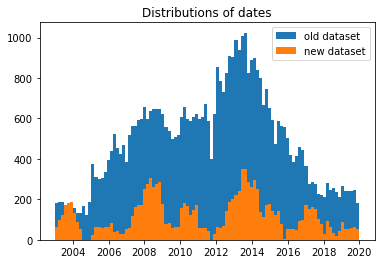

In [5]:
date_ranges = pd.read_csv('metadata/date_ranges_of_stations.csv', parse_dates=['start_date', 'end_date'], dayfirst=True)
date_ranges.head()

new_data = []

for c in cities:
    sd = date_ranges.start_date.loc[date_ranges.station == c].iloc[0]
    ed = date_ranges.end_date.loc[date_ranges.station == c].iloc[0]
    c_data = data.loc[data.station == c]
    c_data = c_data.loc[c_data.date >= sd]
    c_data = c_data.loc[c_data.date <= ed]
    new_data.append(c_data)

new_data = pd.concat(new_data)
new_data = new_data.reset_index(drop=True)

plt.hist(data.date, bins=100, label='old dataset')
plt.hist(new_data.date, bins=100, label='new dataset')
plt.title('Distributions of dates')
plt.legend()

old_data = data
data = new_data

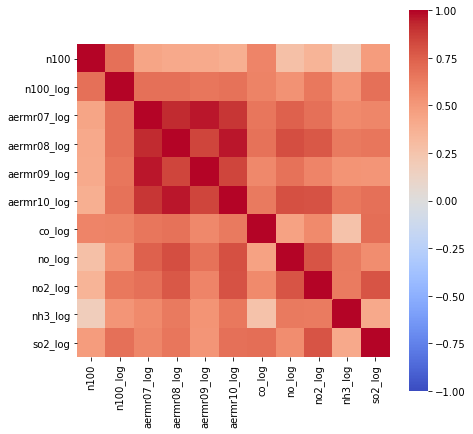

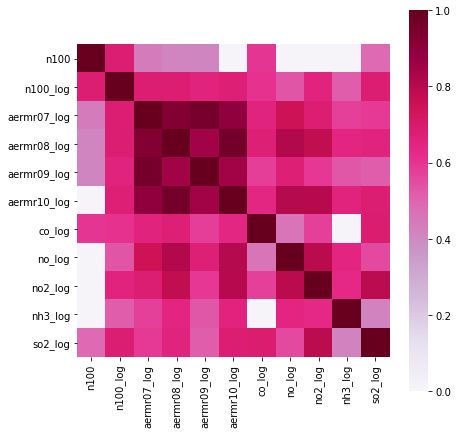

In [14]:
# predictors = all_vars
# predictors = ['aermr_dust', 'aermr07', 'aermr10', 'co', 'no', 'no2', 'nh3', 'so2', 'co_log']
# predictors = ['latitude', 'aermr_dust', 'aermr07', 'co', 'no', 'no2', 'nh3', 'so2', 'co_log']
# predictors = ['aermr07', 'aermr08', 'aermr09', 'aermr10', 'co', 'no', 'no2', 'nh3', 'so2']
predictors = ['aermr07_log', 'aermr08_log', 'aermr09_log', 'aermr10_log', 
              'co_log', 'no_log', 'no2_log', 'nh3_log', 'so2_log']

corr = data[['n100', 'n100_log']+predictors].corr()

plt.figure(figsize=(7, 7))
sns.heatmap(corr, xticklabels=['n100', 'n100_log']+predictors, yticklabels=['n100', 'n100_log']+predictors, 
            cmap='coolwarm', cbar=True, square=True, vmin=-1, vmax=1)

corr_coll = np.abs(corr)
corr_coll[corr_coll < 0.4] = 0
plt.figure(figsize=(7, 7))
sns.heatmap(corr_coll, xticklabels=['n100', 'n100_log']+predictors, yticklabels=['n100', 'n100_log']+predictors, 
            cmap='PuRd', cbar=True, square=True, vmin=0, vmax=1);

In [15]:
# low n100 concentrations
# ["ALE", "AMA", "ASP", "BOT", "EGB", "HEL", "HPB", 
#  "HYY", "MHD", "SCH", "SGP", "VAR", "VIE", "ZOT"]

# medium n100 concentrations
# ["ABZ", "AMM", "BSL", "FKL", "HRW", "KCE", "KPZ", "MAR", "MLP", 
#  "MUK", "NEU", "UAE", "WAL"]

# high n100 concentrations
# ["BEI", "DEL", "HAD", "NAN", "POV", "SAO", "VHL"]  # VHL is probably incorrectly sorted into this group

# training stations
# train_stations = ["AMA", "BEI", "BSL", "DEL",
#                   "HYY", "KPZ", "MAR", "MHD",
#                   "MLP", "POV", "SCH", "SGP",
#                   "UAE", "VAR", "VIE", "WAL"]

# testing stations
# test_stations = ["ABZ", "ALE", "AMM", "ASP",
#                  "BOT", "EGB", "HAD", "HEL",
#                  "HPB", "KCE", "MUK", "NAN", 
#                  "NEU", "SAO", "ZOT"]

# train_data = data[[s in train_stations for s in data.station]]
# train_data.reset_index(inplace=True)
# test_data = data[[s in test_stations for s in data.station]]
# test_data.reset_index(inplace=True)

log_transf_n100 = True

r2_all, r2_log_all, rmsle_all, rmse_log_all = [], [], [], []
all_predictions, all_log_predictions = [], []
all_observations, all_log_observations = [], []
coefficients, intercepts = [], []

# training the model using 1 year of data for all but one station 
# and testing the model on one year of data of the remaining station
for station in cities:
    print('Test station:', station)

    # creating the train and test sets
    train_indices, test_indices = select_indices_station(data, station)
    tr_te_sets = make_train_test_sets(data, predictors, train_indices, test_indices, log_transf_n100)
    X_train, X_test, y_train, y_test, log_y_test, orig_y_test = tr_te_sets
    
    # ------------------------------------------------------------------
    # keras linear regression model
#     model = tf.keras.Sequential([layers.Dense(1, use_bias=True)])
#     model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), 
#                   loss='mse')  # mean_squared_logarithmic_error
#     history = model.fit(X_train, y_train, epochs=50, verbose=0,
#                         validation_split = 0.2, batch_size=100)
    
    # plotting the losses
#     plt.plot(np.sqrt(history.history['loss']), label='loss')
#     plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('RMSE')
#     plt.legend()
#     plt.grid(True)
    # ------------------------------------------------------------------

    # sklearn linear regression model
    model = LinearRegression().fit(X_train, y_train)
    print_equation(model)
    
    # making test set predictions
    predictions = model.predict(X_test)
    log_predictions = None
    if log_transf_n100:
        predictions[predictions <= 0] = 0
        log_predictions = predictions
        predictions = np.exp(predictions)
        predictions[predictions <= 1] = 1
    else:
        predictions[predictions <= 1] = 1
        log_predictions = np.log(predictions)
        
    all_observations.extend(orig_y_test)
    all_log_observations.extend(log_y_test)
    all_predictions.extend(predictions)
    all_log_predictions.extend(log_predictions)
    coefficients.append(model.coef_)
    intercepts.append(model.intercept_)
    
#     corr_eval(predictions, orig_y_test, station=station)
#     corr_eval(log_predictions, log_y_test, log_transf=True, station=station)

    # evaluating the model performance
    r2, r2_log, rmsle, rmse_log = eval_model(predictions, log_predictions, model)
    r2_all.append(r2) 
    r2_log_all.append(r2_log)
    rmsle_all.append(rmsle)
    rmse_log_all.append(rmse_log) 
    
    print('R^2:\t', r2, '\t\tR^2 (log-transformed data):\t', r2_log)
    print('RMSLE:\t', rmsle, '\t\tRMSE (log-transformed data):\t', rmse_log)
    print()
        
print('Median of results:')
print('R^2:\t', np.round(np.median(r2_all), 3), 
      '\t\tR^2 (log-transformed data):\t', np.round(np.mean(r2_log_all), 3))
print('RMSLE:\t', np.round(np.median(rmsle_all), 3), 
      '\t\tRMSE (log-transformed data):\t', np.round(np.mean(rmse_log_all), 3))

Test station: ABZ
Model equation:
n100_log = - 0.21*aermr07_log + 0.186*aermr08_log + 0.463*aermr09_log - 0.204*aermr10_log + 0.253*co_log - 0.034*no_log + 0.098*no2_log + 0.05*nh3_log + 0.227*so2_log + 22.801

R^2:	 -0.0403 		R^2 (log-transformed data):	 0.1775
RMSLE:	 0.5208 		RMSE (log-transformed data):	 0.5212

Test station: ALE
Model equation:
n100_log = - 0.371*aermr07_log + 0.491*aermr08_log + 0.632*aermr09_log - 0.508*aermr10_log + 0.16*co_log - 0.002*no_log + 0.088*no2_log + 0.08*nh3_log + 0.237*so2_log + 22.614

R^2:	 -271.1927 		R^2 (log-transformed data):	 -2.964
RMSLE:	 1.714 		RMSE (log-transformed data):	 1.8839

Test station: AMA
Model equation:
n100_log = - 0.2*aermr07_log + 0.108*aermr08_log + 0.442*aermr09_log - 0.165*aermr10_log + 0.251*co_log - 0.03*no_log + 0.158*no2_log + 0.044*nh3_log + 0.242*so2_log + 23.249

R^2:	 -0.4987 		R^2 (log-transformed data):	 -0.3351
RMSLE:	 1.2784 		RMSE (log-transformed data):	 1.3238

Test station: AMM
Model equation:
n100_log = 

Model equation:
n100_log = - 0.159*aermr07_log + 0.184*aermr08_log + 0.411*aermr09_log - 0.2*aermr10_log + 0.244*co_log - 0.037*no_log + 0.127*no2_log + 0.047*nh3_log + 0.208*so2_log + 22.615

R^2:	 0.1287 		R^2 (log-transformed data):	 -0.2213
RMSLE:	 0.9701 		RMSE (log-transformed data):	 0.974

Test station: SGP
Model equation:
n100_log = - 0.203*aermr07_log + 0.199*aermr08_log + 0.458*aermr09_log - 0.219*aermr10_log + 0.239*co_log - 0.034*no_log + 0.105*no2_log + 0.05*nh3_log + 0.228*so2_log + 22.681

R^2:	 0.0852 		R^2 (log-transformed data):	 0.1615
RMSLE:	 0.5938 		RMSE (log-transformed data):	 0.5954

Test station: UAE
Model equation:
n100_log = - 0.197*aermr07_log + 0.195*aermr08_log + 0.456*aermr09_log - 0.214*aermr10_log + 0.239*co_log - 0.038*no_log + 0.118*no2_log + 0.048*nh3_log + 0.225*so2_log + 22.862

R^2:	 -0.58 		R^2 (log-transformed data):	 -0.4928
RMSLE:	 0.5998 		RMSE (log-transformed data):	 0.6004

Test station: VAR
Model equation:
n100_log = - 0.203*aermr07_log

Correlation between observed and predicted n100 concentration: 0.555
Correlation between observed and predicted n100 concentration (log-transformed): 0.745


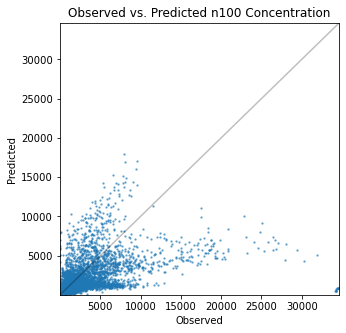

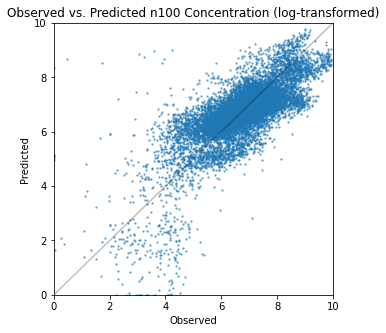

In [16]:
corr_eval(all_predictions, np.array(all_observations))
corr_eval(all_log_predictions, np.array(all_log_observations), log_transf=True)

In [18]:
# plt.hist(data.n100_log, bins=100, label='whole dataset');
# plt.hist(train_data.n100_log, bins=100, label='train dataset', alpha=0.75, color='darkorange')
# plt.hist(test_data.n100_log, bins=100, label='test dataset', alpha=0.5, color='gold')
# plt.title('Distributions of log-transformed n100 concentrations')
# plt.legend();

In [15]:
# print(len(train_data.n100_log))
# print(len(test_data.n100_log))

In [16]:
# print(min(train_data.n100_log), max(train_data.n100_log))
# print(min(test_data.n100_log), max(test_data.n100_log))

In [17]:
# mannwhitneyu(train_data.n100_log, test_data.n100_log)

Model equation:
n100_log = - 0.205*aermr07_log + 0.194*aermr08_log + 0.457*aermr09_log - 0.212*aermr10_log + 0.248*co_log - 0.033*no_log + 0.105*no2_log + 0.05*nh3_log + 0.226*so2_log + 22.783

Correlation between observed and predicted n100 concentration: 0.573
Correlation between observed and predicted n100 concentration (log-transformed): 0.785
R2 value on test set: 0.305000
R2 value on test set (log-transformed): 0.610200
RMSLE on test set: 0.704000
RMSE on test set (log_transformed): 0.706800


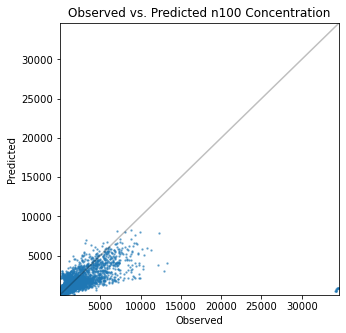

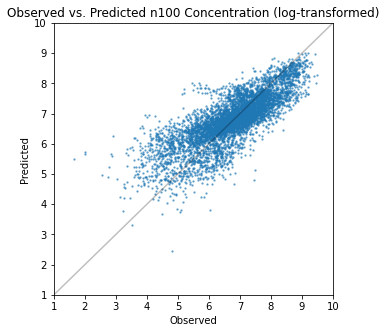

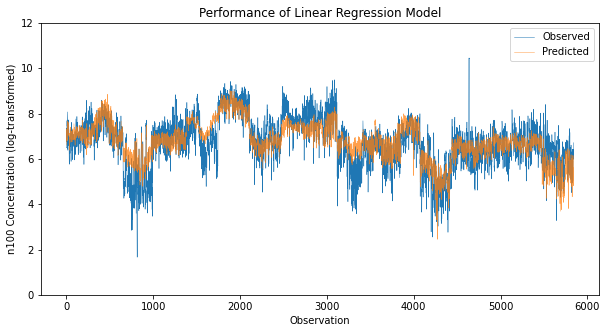

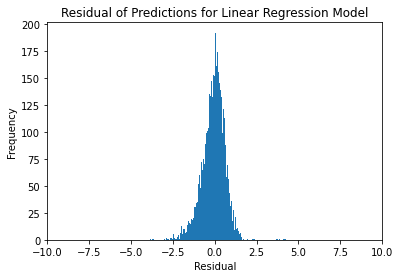

In [17]:
log_transf_n100 = True
train_indices, test_indices = select_indices_percent(data, train_frac=0.5, shuffle=False)
tr_te_sets = make_train_test_sets(data, predictors, train_indices, test_indices, log_transf_n100)
X_train, X_test, y_train, y_test, log_y_test, orig_y_test = tr_te_sets

# ------------------------------------------------------------------
# keras linear regression model
# model = tf.keras.Sequential([layers.Dense(1, use_bias=True)])
# model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
#               loss='mean_squared_logarithmic_error')
# history = model.fit(X_train, y_train, epochs=100, verbose=0,
#                     validation_split = 0.2, batch_size=10)

# plotting the losses
# plt.plot(np.sqrt(history.history['loss']), label='loss')
# plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('RMSLE')
# plt.legend()
# plt.grid(True)
# ------------------------------------------------------------------

# sklearn linear regression model using training set
# model = LinearRegression().fit(X_train, y_train)

# sklearn linear regression model with parameters from cross-validation approach
model = LinearRegression()
model.coef_ = np.mean(coefficients, axis=0)
model.intercept_ = np.mean(intercepts)

# making test set predictions
predictions = model.predict(X_test)  # [:,0]
log_predictions = None
if log_transf_n100:
    predictions[predictions <= 0] = 0
    log_predictions = predictions
    predictions = np.exp(predictions)
    predictions[predictions <= 1] = 1
else:
    predictions[predictions <= 1] = 1
    log_predictions = np.log(predictions)

# printing the model evaluation
print_equation(model)

# plotting observed vs. predicted n100 concentrations
corr_eval(predictions, orig_y_test)
corr_eval(log_predictions, log_y_test, log_transf=True)

# evaluating the model performance
r2, r2_log, rmsle, rmse_log = eval_model(predictions, log_predictions, model, print_results=True)

# plotting the observed and predicted n100 concentrations against time in log-scale
plot_results('Linear Regression', log_predictions)
plot_residuals('Linear Regression', log_predictions)


# RESULTS:
# --------
# Model equation:
# n100 = 14758862692.023*aermr07 + 132219855877.617*aermr08 + 628975812607.421*aermr09 - 1260338261994.197*aermr10 
# - 2563870865.725*co + 15032062913.98*no + 39638527955.971*no2 + 121186365213.411*nh3 - 20397082108.578*so2 + 460.015

# Correlation between observed and predicted n100 concentration: 0.511
# Correlation between observed and predicted n100 concentration (log-transformed): 0.609
# R2 value on test set: 0.233800
# R2 value on test set (log-transformed): 0.359500
# RMSLE on test set: 1.027600
# RMSE on test set (log_transformed): 0.164100

Correlation between observed and predicted n100 concentration: 0.364
Correlation between observed and predicted n100 concentration (log-transformed): 0.787


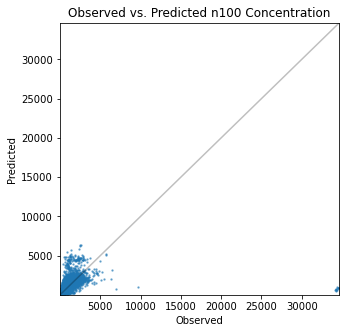

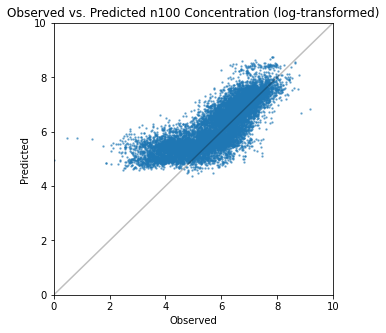

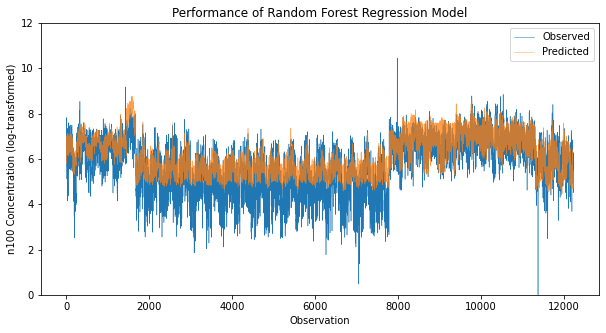

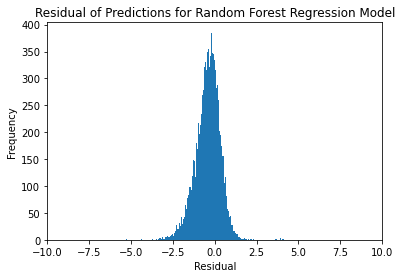

In [18]:
log_transf_n100 = False
train_indices, test_indices = select_indices_percent(old_data, shuffle=False)
tr_te_sets = make_train_test_sets(old_data, all_vars, train_indices, test_indices, log_transf_n100)
X_train, X_test, y_train, y_test, log_y_test, orig_y_test = tr_te_sets

# fitting the random forest regression model
model = RandomForestRegressor(max_depth=10).fit(X_train, y_train)

# making test set predictions
predictions = model.predict(X_test)
log_predictions = None
if log_transf_n100:
    predictions[predictions <= 0] = 0
    log_predictions = predictions
    predictions = np.exp(predictions)
    predictions[predictions <= 1] = 1
else:
    predictions[predictions <= 1] = 1
    log_predictions = np.log(predictions)

# plotting observed vs. predicted n100 concentrations
corr_eval(predictions, orig_y_test)
corr_eval(log_predictions, log_y_test, log_transf=True)

# evaluating the model performance
eval_model(predictions, log_predictions, model)
        
# plotting the observed and predicted n100 concentrations against time
plot_results('Random Forest Regression', log_predictions)
plot_residuals('Random Forest Regression', log_predictions)